# Implementation of a CNN using fashion MNIST dataset

## Imports

In [1]:
# imports
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

## Input pipeline

In [2]:
# Description:Input pipeline to prepare dataset
#             Inputs: fashion_mnist
#             Outputs: prepared fashion_mnist
def prepare_data(fashion_mnist):
        
    #convert datatype to float32 and normalize image pixels to range [-1, 1]
    fashion_mnist = fashion_mnist.map(lambda img, target: ((tf.cast(img, tf.float32) / 128.0) - 1.0, target))
            
    #create one-hot targets
    fashion_mnist = fashion_mnist.map(lambda img, target: (img, tf.one_hot(target, depth=10)))
    #cache this progress in memory, as there is no need to redo it; it is deterministic after all
    fashion_mnist = fashion_mnist.cache()
    
    #shuffle, batch, prefetch
    fashion_mnist = fashion_mnist.shuffle(1000)
    fashion_mnist = fashion_mnist.batch(128)
    fashion_mnist = fashion_mnist.prefetch(150)
    
    #return preprocessed dataset
    return fashion_mnist

## Model

In [3]:
# Description: CNN Model with convolutional and pooling operations and classifier architecture 
#              since this is a classification task
class CNNModel(tf.keras.Model):
    
    # Description: Set up layers
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv_layer1 = tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu', kernel_regularizer= tf.keras.regularizers.l2(0.01), input_shape=(28, 28, 1))
        self.pool_layer1 = tf.keras.layers.MaxPool2D((2, 2), strides = 3)
        self.dropout1 = tf.keras.layers.Dropout(0.2)
        self.conv_layer3 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu', kernel_regularizer= tf.keras.regularizers.l2(0.01))
        
        # flatten input to process it with dense layer
        self.flatten_layer = tf.keras.layers.Flatten()
        self.conv_layer4 = tf.keras.layers.Dense(64, activation='relu', kernel_regularizer= tf.keras.regularizers.l2(0.01))
        self.dropout2 = tf.keras.layers.Dropout(0.5)
        self.output_layer = tf.keras.layers.Dense(10, activation='softmax')
     
    
    # Description: First a python decorater is called to transform the call function to a computational graph
    #              Then the call function passes the inputs through the layers of the model (forward pass)
    #              inputs: input
    #              outputs: final_pass
    @tf.function
    def call(self, inputs):
        x = self.conv_layer1(inputs)
        x = self.pool_layer1(x) 
        x = self.dropout1(x)
        x = self.conv_layer3(x)
        x = self.flatten_layer(x)
        x = self.conv_layer4(x) 
        x = self.dropout2(x)
        x = self.output_layer(x)
        return x

## Training and testing functions

In [4]:
#Description: This function trains an object of the class MyModel. It conducts a forward-step and the backpropagation 
#             throughout the network. The optimizer updates weights and biases. 
#             Inputs: model, inputs, target, loss function, optimizer
#             Outputs:loss, accuracy
def train_step(model, inputs, target, loss_function, optimizer):
    # loss_object and optimizer_object are instances of respective tensorflow classes
    with tf.GradientTape() as tape:
        prediction = model(inputs)
        loss = loss_function(target, prediction)
        sample_train_accuracy =  np.argmax(target, axis=1) == np.argmax(prediction, axis=1)
        sample_train_accuracy = np.mean(sample_train_accuracy)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss, sample_train_accuracy



#Description: This function determines the test loss and test accuracy through a forward step in the network.
#             Inputs: model, test data, loss function
#             Outputs: test loss, test accuracy
def test(model, test_data, loss_function):
    test_accuracy_aggregator = []
    test_loss_aggregator = []

    for (input, target) in test_data:
        prediction = model(input)        
        sample_test_loss = loss_function(target, prediction)
        sample_test_accuracy =  tf.equal(tf.argmax(prediction, 1), tf.argmax(target, 1))
        sample_test_accuracy = np.mean(sample_test_accuracy)
        test_loss_aggregator.append(sample_test_loss.numpy())
        test_accuracy_aggregator.append(np.mean(sample_test_accuracy))

    test_loss = tf.reduce_mean(test_loss_aggregator)
    test_accuracy = tf.reduce_mean(test_accuracy_aggregator)

    return test_loss, test_accuracy

## Visualization

In [5]:
#Description: This function visualizes the losses and accuracies of training and testing 
#             Inputs: test,train,test,train, optimizer label
#             Outputs: plot
def plotting(train_losses, test_losses, train_accuracies, test_accuracies):
    # plot losses
    plt.figure()
    line1, = plt.plot(train_losses)
    line2, = plt.plot(test_losses)
    plt.title("Loss with optimizer Adam")
    plt.xlabel("Training steps")
    plt.ylabel("Loss")
    plt.legend((line1,line2),("Loss train","Loss test"))
    plt.show()
    
    # plot accuracies
    plt.figure()
    line1, = plt.plot(train_accuracies)
    line2, = plt.plot(test_accuracies)
    plt.title("Accuracy with optimizer Adam")
    plt.xlabel("Training steps")
    plt.ylabel("Accuracy")
    plt.legend((line1,line2),("Accuracy train", "Accuracy test"))
    plt.show()

## Main

 test_losses: 0.360801100730896 , test_accuracies: 0.8659018987341772
 test_losses: 0.28801628947257996 , test_accuracies: 0.8944818037974683
 test_losses: 0.2680477797985077 , test_accuracies: 0.900118670886076
 test_losses: 0.25201794505119324 , test_accuracies: 0.9097112341772152
 test_losses: 0.25780433416366577 , test_accuracies: 0.9084256329113924
 test_losses: 0.24255909025669098 , test_accuracies: 0.9122824367088608
 test_losses: 0.24681329727172852 , test_accuracies: 0.9154469936708861
 test_losses: 0.2514566481113434 , test_accuracies: 0.916435917721519
 test_losses: 0.2526269853115082 , test_accuracies: 0.9181170886075949
 test_losses: 0.26858091354370117 , test_accuracies: 0.9146558544303798


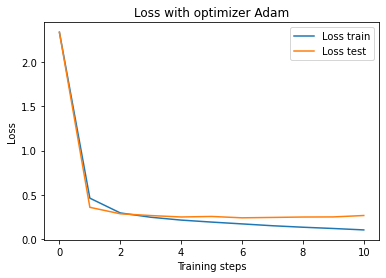

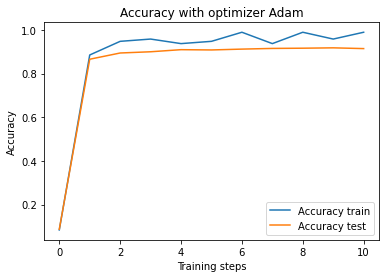

In [6]:
# splitting data
train_ds, test_ds = tfds.load('fashion_mnist', split=['train', 'test'], shuffle_files=True, as_supervised=True)

# prepare data: convert, hotify, shuffle, batch and prefetch
train_dataset = prepare_data(train_ds)
test_dataset = prepare_data(test_ds)

# Training

### Hyperparameters
num_epochs = 10
learning_rate = 0.001
    
# Initialize the optimizers: Adam
opt = tf.keras.optimizers.Adam(learning_rate)

tf.keras.backend.clear_session()

# Initialize the model.
model = CNNModel()

# Initialize the loss: categorical cross entropy. Check out 'tf.keras.losses'.
c_cross_entropy_loss = tf.keras.losses.CategoricalCrossentropy()


# Initialize lists for later visualization.
train_losses = []
test_losses = []

train_accuracies = []
test_accuracies = []

#testing once before we begin
test_loss, test_accuracy = test(model, test_dataset, c_cross_entropy_loss)
test_losses.append(test_loss)
test_accuracies.append(test_accuracy)

#check how model performs on train data once before we begin
train_loss, train_accuracy = test(model, train_dataset, c_cross_entropy_loss)
train_losses.append(train_loss)
train_accuracies.append(train_accuracy)

# We train for num_epochs epochs
for epoch in range(num_epochs):

    #training (and checking in with training)
    epoch_loss_agg = []
    epoch_acc_agg = []
    for input,target in train_dataset:
        train_loss, train_accuracy = train_step(model, input, target, c_cross_entropy_loss, opt)
        epoch_loss_agg.append(train_loss)

    #track training loss
    train_losses.append(tf.reduce_mean(epoch_loss_agg))
    # tracking train accuracy
    train_accuracies.append(tf.reduce_mean(train_accuracy))

    #testing, so we can track accuracy and test loss
    test_loss, test_accuracy = test(model, test_dataset, c_cross_entropy_loss)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

    print(f' test_losses: {test_losses[-1]} , test_accuracies: {test_accuracies[-1]}')

# Visualization
plotting(train_losses, test_losses, train_accuracies, test_accuracies)